In [ ]:
!pip uninstall -y eonacs && pip install  git+https://github.com/njnmco/smc #--log /dev/stderr

Found existing installation: eonacs 1.0.0
Uninstalling eonacs-1.0.0:
  Successfully uninstalled eonacs-1.0.0
  Cloning https://github.com/njnmco/smc to /tmp/pip-req-build-ka37yryn
  Running command git clone -q https://github.com/njnmco/smc /tmp/pip-req-build-ka37yryn
  Created wheel for eonacs: filename=eonacs-1.0.0-py3-none-any.whl size=2990 sha256=f7906e56cd8d6b1625ba72591d44b0d12e061235b0a8fa5d1cce64e14741e333
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8l5l7ff/wheels/6e/02/6d/470a51584ecf5233c1da27aab5d5e137df8b9ab9cc345b2a49
Successfully built eonacs


In [ ]:
!pip install pacmap

In [ ]:
!wget https://raw.githubusercontent.com/YingfanWang/PaCMAP/master/source_code/pacmap/pacmap.py -O pacmap_devel.py
! sed -i 532d pacmap_devel.py

--2022-03-08 23:11:41--  https://raw.githubusercontent.com/YingfanWang/PaCMAP/master/source_code/pacmap/pacmap.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25502 (25K) [text/plain]
Saving to: ‘pacmap_devel.py’

pacmap_devel.py     100%[===================>]  24.90K  --.-KB/s    in 0.002s  

2022-03-08 23:11:41 (16.0 MB/s) - ‘pacmap_devel.py’ saved [25502/25502]



In [ ]:
import eonacs.common.util as util

util.colab_map_drive()


Mounted at /content/drive


In [ ]:
con = util.onet_db()

In [ ]:
import pandas as pd
import numpy as np
import torch

In [ ]:
tasks = pd.read_sql("select distinct substr(onetsoc_code, 1, 2) as soc,  task as text from task_statements",   con)
#dwa = pd.read_sql("select * from dwa_reference",   con)

In [ ]:
tasks.head()

,soc,text
0,11,Direct or coordinate an organization's financi...
1,11,Appoint department heads or managers and assig...
2,11,Analyze operations to evaluate performance of ...
3,11,"Direct, plan, or implement policies, objective..."
4,11,"Prepare budgets for approval, including those ..."


In [ ]:
import eonacs.common.reduction as reduction
import eonacs.common.dbert as dbert

In [ ]:
from transformers import AutoModel
tokenizer, model = dbert.dbert()
fine  = AutoModel.from_pretrained("/content/drive/MyDrive/smc/models/dbert_tasks/")
hyper = AutoModel.from_pretrained("/content/drive/MyDrive/smc/models/dbert_tasks_hyper/")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /content/drive/MyDrive/smc/models/dbert_tasks/ were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_

In [ ]:
hyper_e = dbert.get_embeddings(tasks['text'], tokenizer, hyper)

Using cuda:0
0...
1024...
2048...
3072...
4096...
5120...
6144...
7168...
8192...
9216...
10240...
11264...
12288...
13312...
14336...
15360...
16384...
17408...


In [ ]:
import plotnine as p9

In [ ]:
import pacmap_devel as pacmap

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
#import pacmap
from sklearn.preprocessing import StandardScaler

pmap = pacmap.PaCMAP(n_dims=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 


In [ ]:
features = hyper_e
scale = StandardScaler()
features = scale.fit_transform(features)
pmap = pacmap.PaCMAP(n_dims=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=.2) 
embedding, o = pmap.fit_transform(features, Xp=features[1:2,:])

In [ ]:
df = pd.concat([tasks, pd.DataFrame(embedding, columns=['x','y']) ], axis=1)
(p9.ggplot(df) + 
   p9.aes(x='x', y='y', color='factor(soc)') + 
   p9.geom_point() +
   p9.ggtitle("packmap / baseline")
)

(array([[ 1.9839895 ,  0.09766268],
        [ 0.59986305, -0.70615417],
        [ 1.270484  ,  1.5065436 ],
        ...,
        [-2.4127173 ,  0.9477188 ],
        [-1.1828976 ,  0.52071416],
        [ 2.6166341 , -1.6888711 ]], dtype=float32),
 array([[ 0.7422884 , -0.72393715]], dtype=float32))

In [118]:
class PaCMAP2(pacmap.PaCMAP):

  def fit(self, X, *args, **kwargs):
    super().fit(X, Xp=X[:2, :], *args, **kwargs)
    self.X = X
    self.embedding_ = self.embedding_[0]
    self.proj = np.linalg.lstsq(self.X, self.embedding_)[0]


  def transform(self, Xp, iters=None, lr=None):

    new_embed = np.concatenate((
        self.embedding_, 
        np.matmul(Xp, self.proj)
    ))

    new_embed, _, _, _, _ = pacmap.pacmap(
        self.X,
        self.n_dims,
        self.n_neighbors,
        self.n_MN,
        self.n_FP,
        self.pair_neighbors,
        self.pair_MN,
        self.pair_FP,
        self.distance,
        lr or self.lr,
        iters or self.num_iters,
        new_embed, ### !!!
        self.apply_pca,
        self.verbose,
        self.intermediate,
        self.random_state, Xp
    )

    proj = np.linalg.lstsq(new_embed[0], self.embedding_)[0]

    #print(proj)

    new_embed = [np.matmul(x, proj) for x in new_embed]

    return new_embed


In [126]:
pmap2 = PaCMAP2(n_dims=3, n_neighbors=None, MN_ratio=0.5, FP_ratio=.2, verbose=True)
pmap2.fit(features)


PaCMAP(n_neighbors=14, n_MN=7, n_FP=3, distance=euclidean, lr=1.0, n_iters=450, apply_pca=False, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
X is normalized
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
Found nearest neighbor
Calculated sigma
Found scaled dist
Initial Loss: 85611.625
Iteration:   10, Loss: 139700.343750
Iteration:   20, Loss: 98280.843750
Iteration:   30, Loss: 84844.531250
Iteration:   40, Loss: 81243.648438
Iteration:   50, Loss: 78136.093750
Iteration:   60, Loss: 75894.796875
Iteration:   70, Loss: 73757.703125
Iteration:   80, Loss: 71497.953125
Iteration:   90, Loss: 68920.210938
Iteration:  100, Loss: 65785.546875
Iteration:  110, Loss: 90681.789062
Iteration:  120, Loss: 90599.132812
Iteration:  130, Loss: 90573.367188
Iteration:  140, Loss: 90566.437500
Iteration:  150, Loss: 90565.453125
Iteration:  160, Loss: 90566.984375
Iteration:  170, Loss: 90566.679688
Iteration:  180, Loss: 90567

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


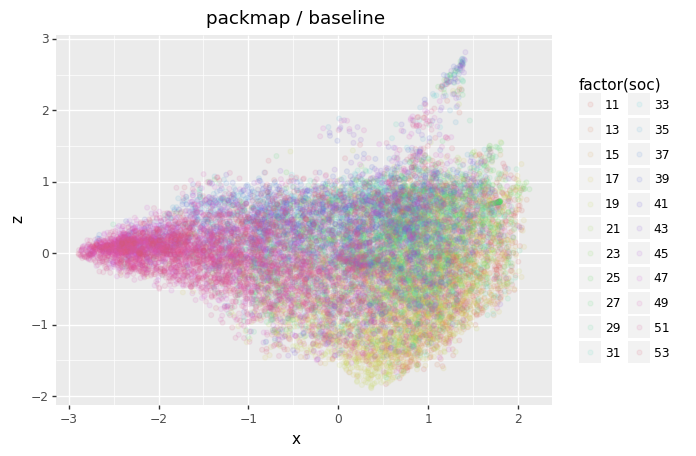

<ggplot: (8760667219825)>

In [143]:
df = pd.concat([tasks, pd.DataFrame(pmap2.embedding_, columns=['x','y','z']) ], axis=1)
(p9.ggplot(df) + 
   p9.aes(x='x', y='z', color='factor(soc)') + 
   p9.geom_point(alpha=.1) +
   p9.ggtitle("packmap / baseline")
)

In [128]:
# e2, e2_xp = pmap.fit_transform(features, Xp=features[:2,:])

In [133]:
f2_xp = pmap2.transform(features[:2,:])

Using stored pairs.


/content/pacmap_devel.py:484: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if Yinit is None or Yinit == "pca":
/content/pacmap_devel.py:503: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Yinit == "random":


Found nearest neighbor
Calculated sigma
Found scaled dist
Initial Loss: 85610.96875
Iteration:   10, Loss: 129880.398438
Iteration:   20, Loss: 96121.406250
Iteration:   30, Loss: 84753.023438
Iteration:   40, Loss: 80673.296875
Iteration:   50, Loss: 78129.554688
Iteration:   60, Loss: 75872.125000
Iteration:   70, Loss: 73741.937500
Iteration:   80, Loss: 71498.703125
Iteration:   90, Loss: 68916.562500
Iteration:  100, Loss: 65788.921875
Iteration:  110, Loss: 90768.781250
Iteration:  120, Loss: 90628.843750
Iteration:  130, Loss: 90586.945312
Iteration:  140, Loss: 90572.648438
Iteration:  150, Loss: 90570.531250
Iteration:  160, Loss: 90571.304688
Iteration:  170, Loss: 90574.265625
Iteration:  180, Loss: 90577.234375
Iteration:  190, Loss: 90578.851562
Iteration:  200, Loss: 90586.468750
Iteration:  210, Loss: 38772.253906
Iteration:  220, Loss: 38481.906250
Iteration:  230, Loss: 38429.546875
Iteration:  240, Loss: 38389.195312
Iteration:  250, Loss: 38368.328125
Iteration:  260

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [134]:
#(e2, e2_xp)

In [135]:
pmap2.embedding_

array([[ 0.37076512, -0.07680283, -0.15923606],
       [ 0.22451048, -0.0594519 , -0.20704985],
       [ 0.8694005 ,  0.11307774, -1.5613633 ],
       ...,
       [-2.1917834 ,  0.8947096 , -0.2582896 ],
       [-0.81966794,  0.90851414,  0.5348969 ],
       [ 1.2006987 , -0.12343651,  2.4217412 ]], dtype=float32)

In [136]:
f2_xp

[array([[ 0.37097615, -0.06287252, -0.16225262],
        [ 0.22472031, -0.045586  , -0.2100529 ],
        [ 0.8696228 ,  0.12762876, -1.5645276 ],
        ...,
        [-2.1915812 ,  0.90761304, -0.2611065 ],
        [-0.8194575 ,  0.92202306,  0.53195083],
        [ 1.2009057 , -0.10958166,  2.41875   ]], dtype=float32),
 array([[ 0.22866173,  0.23761018, -0.12579532],
        [ 0.22866276,  0.23760998, -0.1257955 ]], dtype=float32)]

In [ ]:
pmap2.proj.shape

(768, 2)

In [ ]:
!pip install  git+https://github.com/YingfanWang/PaCMAP


  Cloning https://github.com/YingfanWang/PaCMAP to /tmp/pip-req-build-f10dvyho
  Running command git clone -q https://github.com/YingfanWang/PaCMAP /tmp/pip-req-build-f10dvyho
ERROR: File "setup.py" not found for legacy project git+https://github.com/YingfanWang/PaCMAP.
